In [13]:
import urllib.request
import pandas as pd
import xml.etree.ElementTree as ET
import requests
import xml.etree.ElementTree as ET

def get_daily_treasury_yield(year):
    url = f'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value={year}'
    response = requests.get(url)
    root = ET.fromstring(response.content)
    data = {}

    for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
        content = entry.find('{http://www.w3.org/2005/Atom}content')
        properties = content.find('{http://schemas.microsoft.com/ado/2007/08/dataservices/metadata}properties')
        date = properties.find('{http://schemas.microsoft.com/ado/2007/08/dataservices}NEW_DATE').text
        data[date] = {}
        for child in properties:
            if 'BC_' in child.tag:
                data[date][child.tag.split('BC_')[1]] = child.text

    df = pd.DataFrame(data).T
    df.index.name = 'date'
    df = df[['3MONTH', '6MONTH', '1YEAR', '2YEAR', '3YEAR', '5YEAR', '7YEAR', '10YEAR']]
    df = df.astype(float)
    return df

def get_treasury_yield_range(start_year, end_year):
    dfs = []
    for year in range(start_year, end_year+1):
        df = get_daily_treasury_yield(year)
        dfs.append(df)
    result = pd.concat(dfs)
    return result

In [14]:
df = get_treasury_yield_range(1990,2024)
df.head()

,3MONTH,6MONTH,1YEAR,2YEAR,3YEAR,5YEAR,7YEAR,10YEAR
date,,,,,,,,
1990-01-02T00:00:00,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94
1990-01-03T00:00:00,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99
1990-01-04T00:00:00,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98
1990-01-05T00:00:00,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99
1990-01-08T00:00:00,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02


In [15]:
df.index = pd.to_datetime(df.index).date
df

,3MONTH,6MONTH,1YEAR,2YEAR,3YEAR,5YEAR,7YEAR,10YEAR
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02
...,...,...,...,...,...,...,...,...
2024-10-21,4.73,4.47,4.24,4.02,3.95,3.98,4.07,4.19
2024-10-22,4.72,4.47,4.24,4.03,3.98,4.00,4.10,4.20
2024-10-23,4.73,4.48,4.27,4.07,4.03,4.05,4.14,4.24
2024-10-24,4.70,4.48,4.25,4.07,4.02,4.03,4.12,4.21


In [16]:
!pip install nelson_siegel_svensson

In [17]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols


# We do the fitting and extract the parameters
def get_parameters(row):
  x = np.array([3,6,12,24,36,60,84,120])
  y = row.to_numpy().astype(float)/100
  curve_fit, status = calibrate_nss_ols(x,y)
  return curve_fit.beta0, curve_fit.beta1, curve_fit.beta2

new_df= df.copy()
for index, row in df.iterrows():
  new_df.loc[index,'beta0'], new_df.loc[index,'beta1'], new_df.loc[index,'beta2'] = get_parameters(row)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-18-021dff057288>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["daily_50d_rolling_std"]=new_df["log_ratios"].rolling(50).std()


,3MONTH,6MONTH,1YEAR,2YEAR,3YEAR,5YEAR,7YEAR,10YEAR,beta0,beta1,beta2,inversion,inversion_shifted,ratios,log_ratios,daily_50d_rolling_std
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,0.080322,-0.007467,0.014844,-10.757051,-8.920930,1.205822,0.187161,NaN
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,0.080209,-0.008219,0.015152,-9.758379,-10.757051,0.907161,-0.097435,NaN
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,0.080412,-0.008360,0.013592,-9.618658,-9.758379,0.985682,-0.014422,NaN
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,0.080640,-0.011986,0.020822,-6.728104,-9.618658,0.699485,-0.357411,NaN
1990-01-09,7.80,7.82,7.78,7.91,7.94,7.92,8.05,8.02,0.080622,-0.005654,0.008283,-14.260130,-6.728104,2.119487,0.751174,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-16,4.72,4.42,4.17,3.93,3.84,3.84,3.92,4.02,0.039076,0.004512,0.027612,8.661162,6.404100,1.352440,0.301911,1.202022
2024-10-17,4.74,4.45,4.21,3.96,3.89,3.90,3.99,4.09,0.039840,0.002387,0.031018,16.691057,8.661162,1.927115,0.656024,1.172817
2024-10-18,4.73,4.45,4.19,3.95,3.86,3.88,3.97,4.08,0.039691,0.001057,0.034327,37.551132,16.691057,2.249776,0.810830,1.176283
2024-10-22,4.72,4.47,4.24,4.03,3.98,4.00,4.10,4.20,0.041108,-0.000945,0.033866,-43.487682,-92.927822,0.467973,-0.759345,1.172433


<Axes: title={'center': 'Yield Curve Volatility'}>

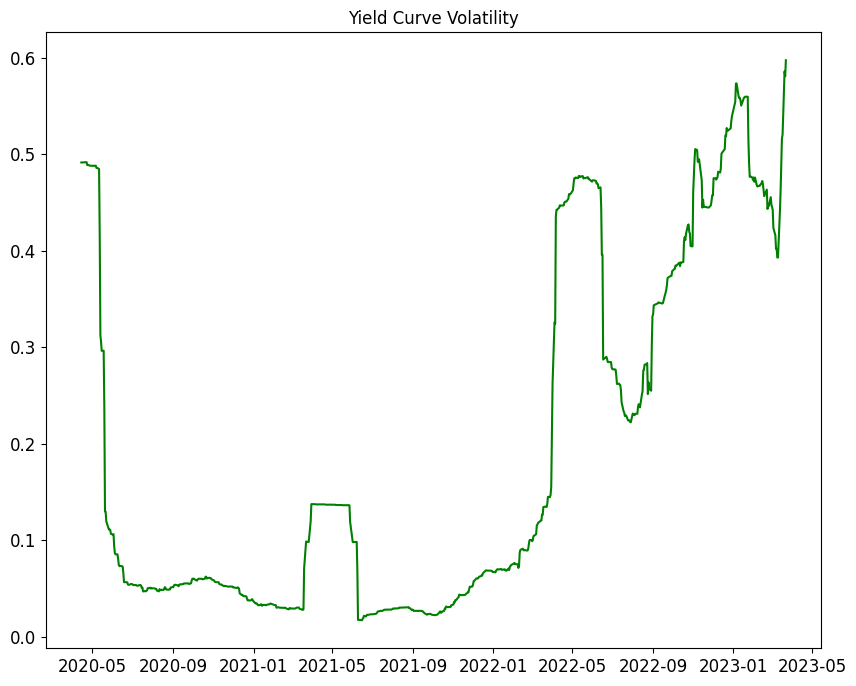

In [18]:
# Create column for the inversion indicator
new_df["inversion"]=new_df["beta0"]/new_df["beta1"]

# Create a column with the values shifted by one row
new_df['inversion_shifted'] = new_df['inversion'].shift(1)

# Create a column "ratios" in the dataframe with the ratio of column "NASDAQCOM" over column "shifted".
# This in turns is equivalent to dividing the price of day i over the price of day i-1
new_df["ratios"]=new_df["inversion"]/new_df["inversion_shifted"]

# Create a column "log_ratios" in the dataframe with the natural logarithm of the ratios of Price
new_df["log_ratios"]=np.log(new_df['ratios'])

new_df=new_df.dropna()

# Create a column with the 50 period rolling standard deviation
new_df["daily_50d_rolling_std"]=new_df["log_ratios"].rolling(50).std()

# Print the first few rows of the data
display(new_df)

# Plot
new_df['daily_50d_rolling_std'].iloc[8247-365*2:8713].plot( y=["daily_50d_rolling_std",], fontsize=12,figsize=(10,8), title="Yield Curve Volatility", color='green')

<Axes: title={'center': 'Yield Curve Volatility'}>

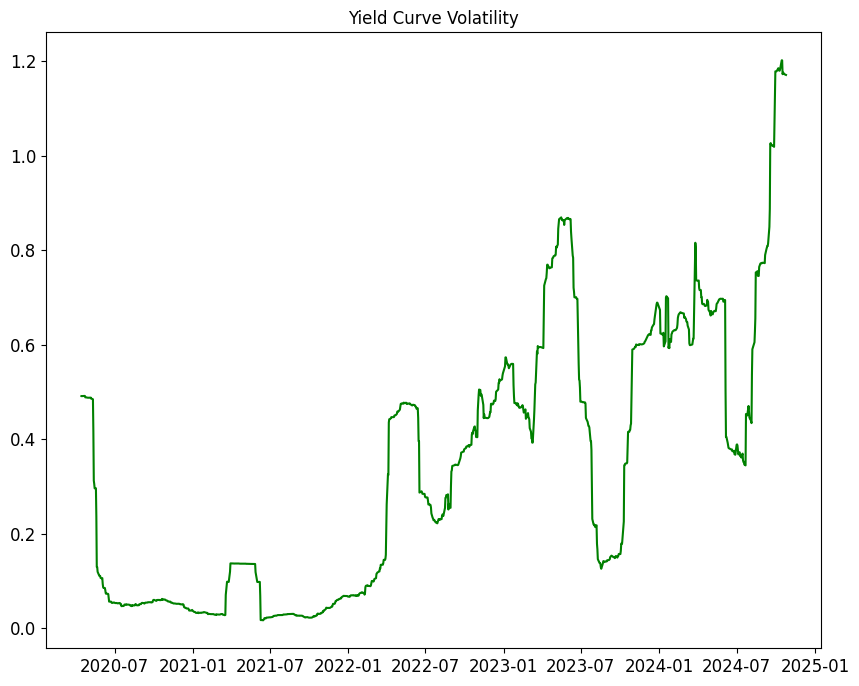

In [19]:

# Plot
new_df['daily_50d_rolling_std'].iloc[8247-365*2:8713].plot( y=["daily_50d_rolling_std",], fontsize=12,figsize=(10,8), title="Yield Curve Volatility", color='green')

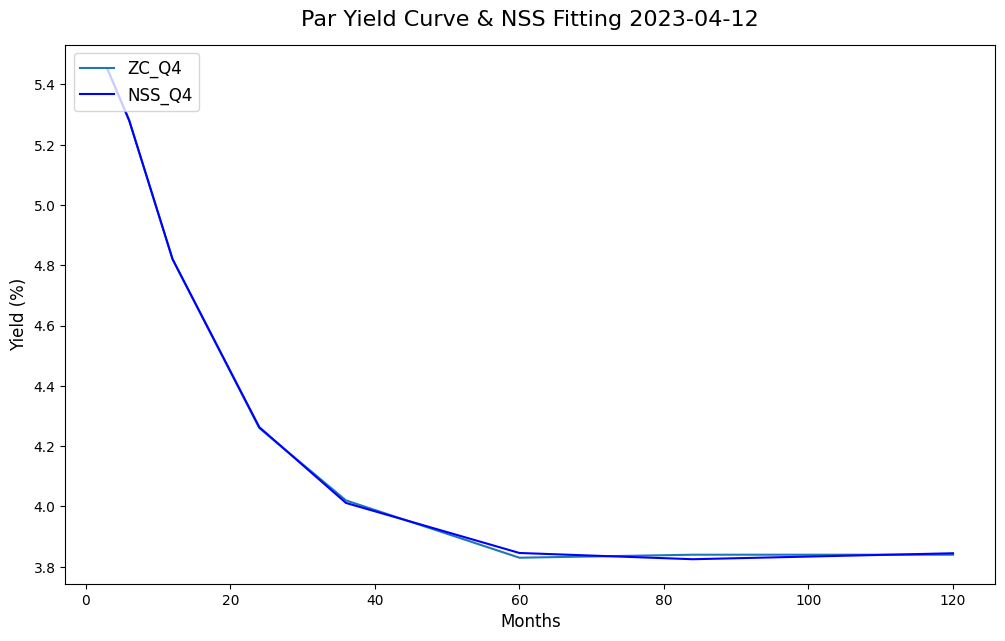

In [9]:
# Plotting the yield curve and the yield curve fit

# Set an array with the last line of the dataframe df
last_row = new_df.iloc[-1]

# Drop all the columns from 9th columns onwards
last_row = last_row[['3MONTH', '6MONTH', '1YEAR', '2YEAR', '3YEAR', '5YEAR', '7YEAR', '10YEAR']]

## Calibrate and Plot the NSS fitting
#     i)Defining a list of x values of market maturities in months
t = np.array([3,6,12,24,36,60,84,120])

#     i)Defining a list of y value of observable market yields for each maturity
y=np.array(last_row)

# b) Mathematical Fitting
# Next, we attempt to calibrate the curve i.e. arrive at the various model parameters. We will do it for both the models stated above
curve_fit, status = calibrate_nss_ols(t,y) #NSS model calibrate, complete (β0, β1, β2, β3 and Ʈ1/2)

# Next, we use the parameters arrived at using step above to build the zero coupon (ZC) and implied forward curve (Fwd)
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
NSS_Fwd = NelsonSiegelSvenssonCurve.forward(curve_fit,t)

# c) Graphical and numerical outputs

mp.figure(figsize=(12, 7))
mp.title('Par Yield Curve & NSS Fitting 2023-04-12', y=1.02, size=16)
mp.xlabel("Months",size=12)
mp.ylabel("Yield (%)",size=12)
mp.plot(t,y,label="ZC_Q4")
mp.plot(t,NSS_ZC,'-b',label='NSS_Q4')
mp.title
mp.legend(loc="upper left", fontsize=12)

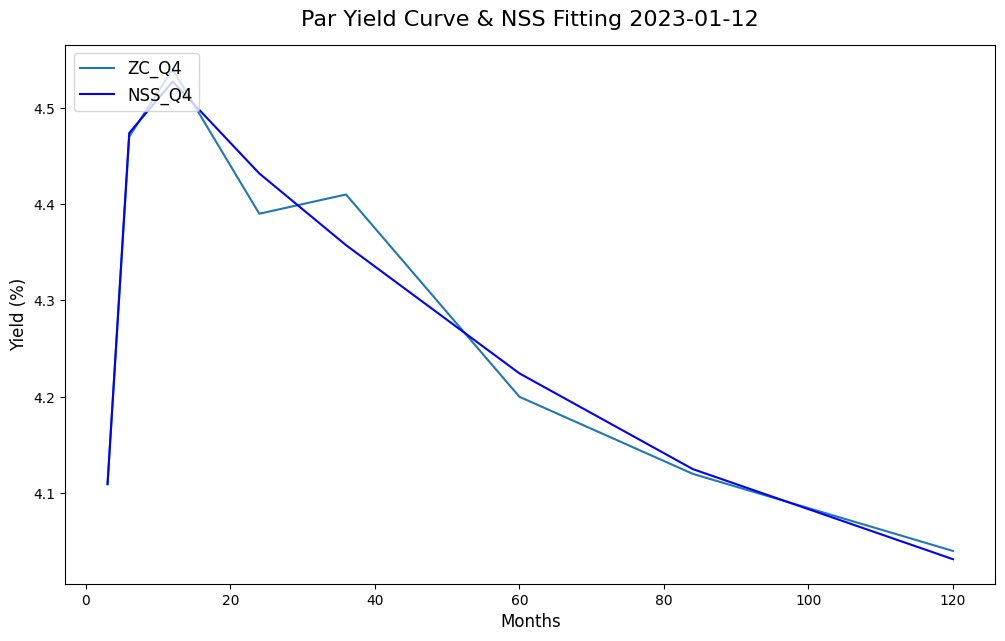

In [ ]:
# Plotting the yield curve and the yield curve fit

# Set an array with the last line of the dataframe df
last_row = new_df.iloc[8110-30*3]

# Drop all the columns from 9th columns onwards
last_row = last_row[['3MONTH', '6MONTH', '1YEAR', '2YEAR', '3YEAR', '5YEAR', '7YEAR', '10YEAR']]

## Calibrate and Plot the NSS fitting
#     i)Defining a list of x values of market maturities in months
t = np.array([3,6,12,24,36,60,84,120])

#     i)Defining a list of y value of observable market yields for each maturity
y=np.array(last_row)

# b) Mathematical Fitting
# Next, we attempt to calibrate the curve i.e. arrive at the various model parameters. We will do it for both the models stated above
curve_fit, status = calibrate_nss_ols(t,y) #NSS model calibrate, complete (β0, β1, β2, β3 and Ʈ1/2)

# Next, we use the parameters arrived at using step above to build the zero coupon (ZC) and implied forward curve (Fwd)
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
NSS_Fwd = NelsonSiegelSvenssonCurve.forward(curve_fit,t)

# c) Graphical and numerical outputs

mp.figure(figsize=(12, 7))
mp.title('Par Yield Curve & NSS Fitting 2023-01-12', y=1.02, size=16)
mp.xlabel("Months",size=12)
mp.ylabel("Yield (%)",size=12)
mp.plot(t,y,label="ZC_Q4")
mp.plot(t,NSS_ZC,'-b',label='NSS_Q4')
mp.title
mp.legend(loc="upper left", fontsize=12)

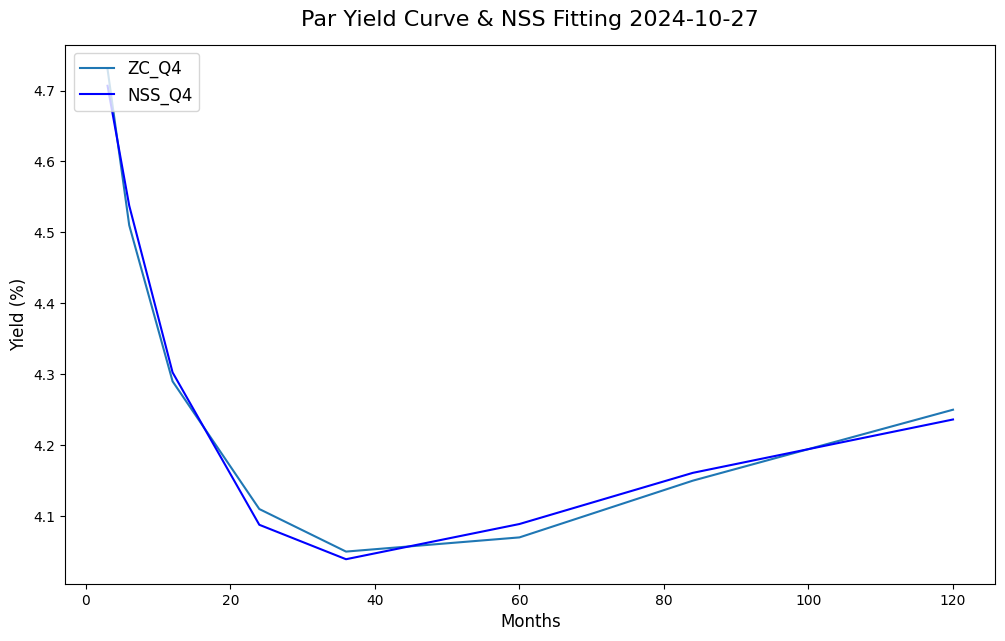

In [20]:
# Plotting the yield curve and the yield curve fit

# Set an array with the last line of the dataframe df
last_row = new_df.iloc[-1]

# Drop all the columns from 9th columns onwards
last_row = last_row[['3MONTH', '6MONTH', '1YEAR', '2YEAR', '3YEAR', '5YEAR', '7YEAR', '10YEAR']]

## Calibrate and Plot the NSS fitting
#     i)Defining a list of x values of market maturities in months
t = np.array([3,6,12,24,36,60,84,120])

#     i)Defining a list of y value of observable market yields for each maturity
y=np.array(last_row)

# b) Mathematical Fitting
# Next, we attempt to calibrate the curve i.e. arrive at the various model parameters. We will do it for both the models stated above
curve_fit, status = calibrate_nss_ols(t,y) #NSS model calibrate, complete (β0, β1, β2, β3 and Ʈ1/2)

# Next, we use the parameters arrived at using step above to build the zero coupon (ZC) and implied forward curve (Fwd)
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
NSS_Fwd = NelsonSiegelSvenssonCurve.forward(curve_fit,t)

# c) Graphical and numerical outputs

mp.figure(figsize=(12, 7))
mp.title('Par Yield Curve & NSS Fitting 2024-10-27', y=1.02, size=16)
mp.xlabel("Months",size=12)
mp.ylabel("Yield (%)",size=12)
mp.plot(t,y,label="ZC_Q4")
mp.plot(t,NSS_ZC,'-b',label='NSS_Q4')
mp.title
mp.legend(loc="upper left", fontsize=12)